# Covid Dataset Analysis

This notebook examines the covid dataset from Our World In Data (retrieved from https://ourworldindata.org/coronavirus on 16th of november 2022). The dataset is used as a horizontal use case for cross-silo federated learning. The goal is to predict the new cases in a single country for the next day, given a selection of attributes of the last *n* days from this country.

## Dataset Description

In [1]:
#import dependencies
import numpy as np
import pandas as pd
import seaborn as sns

from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../scripts')
import helper

2023-02-05 14:01:36.186795: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-05 14:01:37.886046: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-05 14:01:37.886169: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-05 14:01:37.886177: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
#load dataset
data = pd.read_csv("/home/florian/bachelorarbeit/code/Cross-Silo-FL/datasets/horizontal/covid/owid-covid-data.csv")
data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


In [4]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
total_cases,222234.0,4.615235e+06,2.876216e+07,1.000000,4682.000000,5.209450e+04,5.450160e+05,6.361877e+08
new_cases,221975.0,1.222846e+04,8.443724e+04,0.000000,0.000000,5.000000e+01,9.300000e+02,4.081969e+06
new_cases_smoothed,220776.0,1.227039e+04,8.251240e+04,0.000000,5.714000,9.042900e+01,1.102036e+03,3.436034e+06
total_deaths,202942.0,7.524980e+04,3.861887e+05,1.000000,115.000000,1.222000e+03,1.002875e+04,6.614673e+06
new_deaths,202868.0,1.354495e+02,7.208803e+02,0.000000,0.000000,1.000000e+00,1.300000e+01,1.773300e+04
...,...,...,...,...,...,...,...,...
population,234413.0,1.412901e+08,6.936463e+08,47.000000,896007.000000,6.948395e+06,3.369661e+07,7.975105e+09
excess_mortality_cumulative_absolute,7766.0,4.796967e+04,1.325850e+05,-37726.100000,34.600000,6.009500e+03,3.471957e+04,1.224011e+06
excess_mortality_cumulative,7766.0,9.963914e+00,1.354155e+01,-28.450000,0.560000,7.385000e+00,1.560750e+01,7.655000e+01
excess_mortality,7817.0,1.432574e+01,2.639061e+01,-95.920000,-0.120000,7.270000e+00,1.977000e+01,3.765800e+02


In [5]:
data.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

In [7]:
us_data = data[data.iso_code == "USA"]

[Text(0.5, 1.0, 'Total Cases in the USA')]

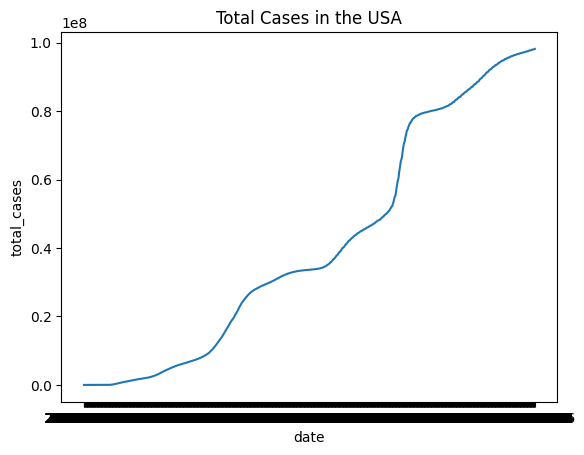

In [18]:
sns.lineplot(us_data, x="date", y="total_cases").set(title="Total cases in the USA")

[Text(0.5, 1.0, 'New cases in the USA')]

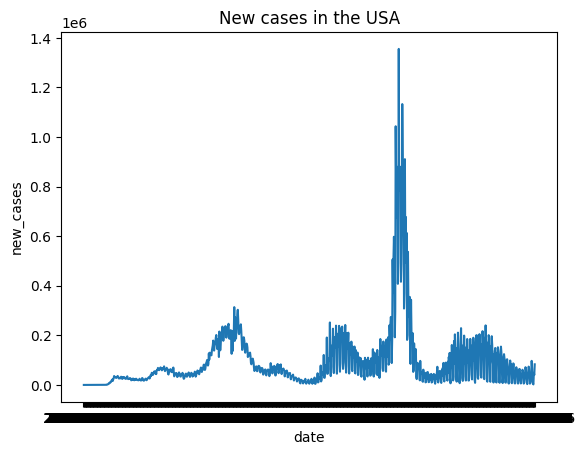

In [19]:
sns.lineplot(us_data, x="date", y="new_cases").set(title="New cases in the USA")

/tmp/ipykernel_15712/600783404.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


<AxesSubplot: >

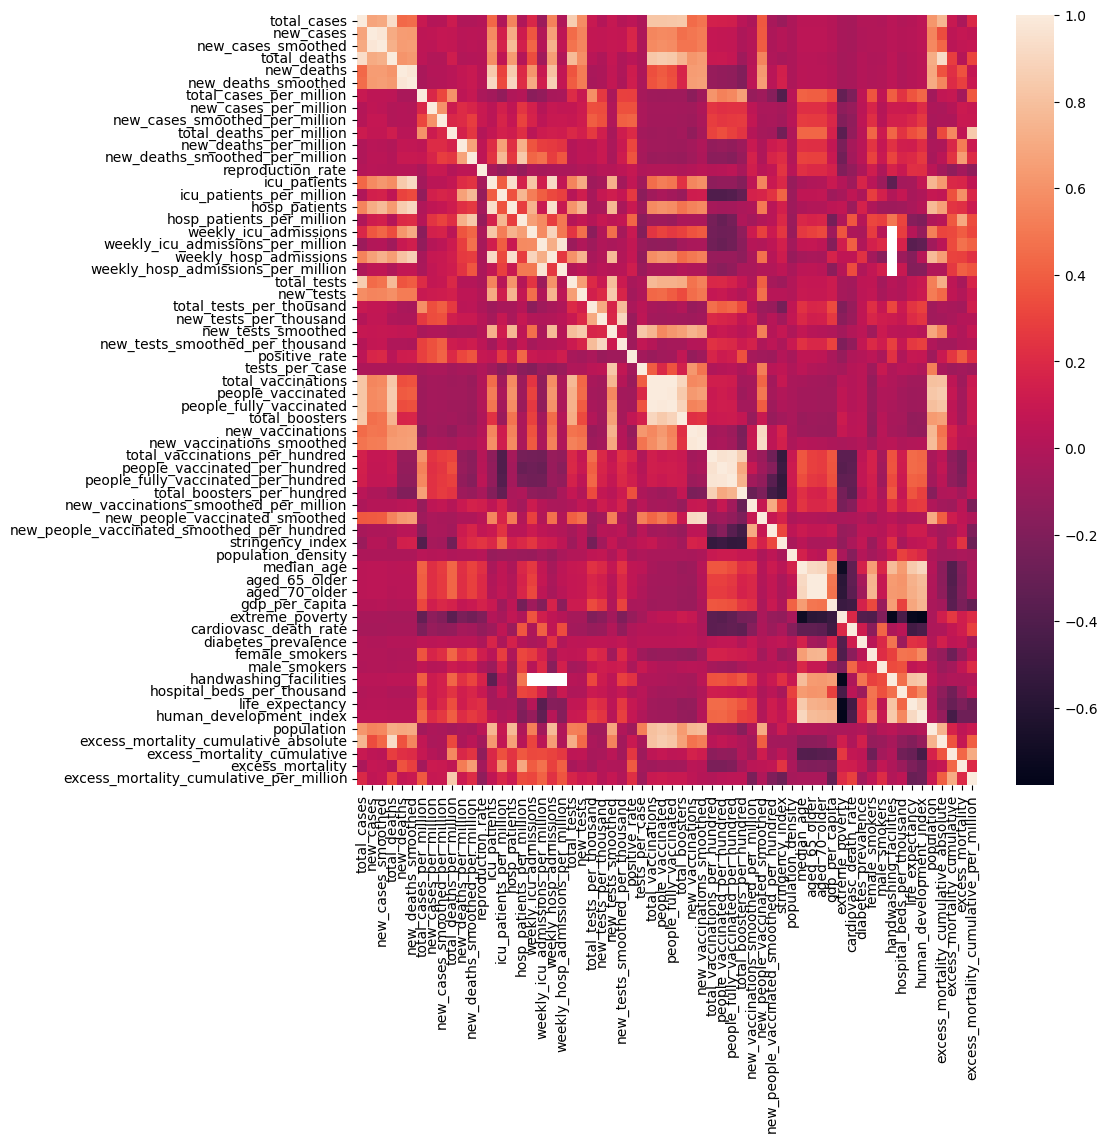

In [28]:
fig, ax = plt.subplots(figsize=(10,10))         

corr = data.corr()
sns.heatmap(corr, xticklabels=True, yticklabels=True, ax=ax)

In [29]:
corr.new_cases.describe()

count    62.000000
mean      0.227245
std       0.280162
min      -0.045469
25%       0.030661
50%       0.071024
75%       0.482332
max       1.000000
Name: new_cases, dtype: float64

In [31]:
corr.new_cases.sort_values(ascending=False).head(n=20)

new_cases                         1.000000
new_cases_smoothed                0.973069
hosp_patients                     0.708799
total_deaths                      0.707655
total_cases                       0.675746
weekly_hosp_admissions            0.664460
new_deaths                        0.645282
new_deaths_smoothed               0.632343
people_vaccinated                 0.568417
icu_patients                      0.567089
people_fully_vaccinated           0.558019
total_vaccinations                0.551471
new_tests                         0.546949
population                        0.542627
new_vaccinations_smoothed         0.509176
new_vaccinations                  0.489044
total_boosters                    0.462194
total_tests                       0.446090
new_people_vaccinated_smoothed    0.386294
weekly_icu_admissions             0.371843
Name: new_cases, dtype: float64

## Model Parameter Selection

This section finds the optimal parameters for models trained on the covid dataset. The selected attributes of this dataset are *new_cases, weekly_hosp_admissions, new_deaths* and *weekly_icu_admissions*. These attributes were chosen based on the correlation with the *new_cases* variable. Some are not inlcuded because they are derived from selected attributes. This is the case for *new_cases_smoothed*. Another reason is the type of given information. Since the task for this model is a time series regression, *total_* attributes are not suited as model inputs, since their values can only go up over time. *new_* values are more suited for this task.

In [15]:
attributes = ["new_cases", "weekly_hosp_admissions", "new_deaths", "weekly_icu_admissions"]
samples = helper.get_samples("covid", 10, attributes, "", True, 100000, True)
samples

(array([[-0.14047992, -0.10645405, -0.1739948 , ..., -0.10645405,
         -0.1739948 , -0.10393099],
        [-0.14054086, -0.10645405, -0.1739948 , ..., -0.10645405,
         -0.1739948 , -0.10393099],
        [-0.14054086, -0.10645405, -0.1739948 , ..., -0.10645405,
         -0.1739948 , -0.10393099],
        ...,
        [-0.13984607, -0.0800012 , -0.16803185, ..., -0.10645405,
         -0.16206889, -0.10393099],
        [-0.13982169, -0.10645405, -0.1739948 , ..., -0.10645405,
         -0.17250406, -0.10393099],
        [-0.14008986, -0.10645405, -0.16057815, ..., -0.10645405,
         -0.16654111, -0.10393099]]),
 array([-0.14054086, -0.14054086, -0.1405043 , ..., -0.13999234,
        -0.14016299, -0.14028489]))

### Linear Regression

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

In [16]:
lm_params = {"fit_intercept": [True, False], "positive": [True, False]}
lm = LinearRegression()
lm_grid = GridSearchCV(lm, lm_params, scoring="neg_mean_absolute_error")

lm_grid.fit(samples[0], samples[1])
lm_grid.best_params_

{'fit_intercept': False, 'positive': True}

### Linear Support Vector Machine

In [17]:
from sklearn.svm import LinearSVR

In [18]:
svm_params = {"epsilon": [0,0.1,0.5,1,2,5,10], "tol": [0.0001, 0.001, 0.01, 0.1, 1, 0.00001], "C": [0.1,0.2,0.5,1,2,5,10]}
svm = LinearSVR()
svm_grid = GridSearchCV(svm, svm_params, scoring="neg_mean_absolute_error")

svm_grid.fit(samples[0], samples[1])

/home/florian/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/florian/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/florian/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/florian/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/florian/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/florian/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinea

GridSearchCV(estimator=LinearSVR(),
             param_grid={'C': [0.1, 0.2, 0.5, 1, 2, 5, 10],
                         'epsilon': [0, 0.1, 0.5, 1, 2, 5, 10],
                         'tol': [0.0001, 0.001, 0.01, 0.1, 1, 1e-05]},
             scoring='neg_mean_absolute_error')

In [17]:
svm_grid.best_params_

{'C': 1, 'epsilon': 0, 'tol': 0.001}

### Multi-Layer Perceptron

In [16]:
import keras_tuner as kt
import tensorflow as tf

In [21]:
#build a sequential model
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(40,)))

    #add dense layers to the model
    for i in range(hp.Int('number of layers', min_value=1, max_value=6)):
        neurons = hp.Int('layer_' + str(i), min_value=8, max_value=512, step=8)
        model.add(tf.keras.layers.Dense(neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(1, activation="linear"))

    hp_learning_rate = hp.Choice("learning_rate", values=[0.1, 0.01, 0.001, 0.0001])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=tf.keras.losses.MeanAbsoluteError(),
        metrics=["mean_absolute_error"])

    return model


tuner = kt.Hyperband(build_model,
                     objective="mean_absolute_error",
                     max_epochs=10,
                     factor=3,
                     directory= "./keras_tuner/covid/",
                     project_name= "covid_mlp_params")

stop_early = tf.keras.callbacks.EarlyStopping(monitor= "val_loss", patience=5)

tuner.search(np.array(samples[0]), np.array(samples[1]), validation_split=0.2, batch_size=1000, epochs=50, callbacks=[stop_early, tf.keras.callbacks.TensorBoard("./keras_tuner/covid/covid_tb_logs")])

tuner.results_summary()


Trial 30 Complete [00h 00m 16s]
mean_absolute_error: 0.18419240415096283

Best mean_absolute_error So Far: 0.022275377064943314
Total elapsed time: 00h 01m 51s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in ./keras_tuner/covid/covid_mlp_params
Showing 10 best trials
Trial summary
Hyperparameters:
number of layers: 3
layer_0: 416
learning_rate: 0.0001
layer_1: 184
layer_2: 344
layer_3: 56
layer_4: 280
layer_5: 408
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0013
Score: 0.022275377064943314
Trial summary
Hyperparameters:
number of layers: 3
layer_0: 240
learning_rate: 0.001
layer_1: 312
layer_2: 176
layer_3: 280
layer_4: 112
layer_5: 328
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0018
Score: 0.022283492609858513
Trial summary
Hyperparameters:
number of layers: 4
layer_0: 96
learning_rate: 0.0001
layer_1: 504
layer_2: 192
layer_3: 376
layer_4: 208
layer_5: 136
tuner/epochs: 10
tuner/

In [22]:
best_model = tuner.get_best_models()[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 416)               17056     
                                                                 
 dense_1 (Dense)             (None, 184)               76728     
                                                                 
 dense_2 (Dense)             (None, 344)               63640     
                                                                 
 dense_3 (Dense)             (None, 1)                 345       
                                                                 
Total params: 157,769
Trainable params: 157,769
Non-trainable params: 0
_________________________________________________________________


## CNN

In [25]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Reshape((10, 4), input_shape=(40,)))
    #add Conv1D layers to the model
    for i in range(hp.Int('number of layers', min_value=1, max_value=4)):
        filters = hp.Int('filter_' + str(i), min_value=32, max_value=128, step=32)
        kernel_size = hp.Int('kernel_' + str(i), min_value=2, max_value=5, step=1)
        model.add(tf.keras.layers.Conv1D(filters, kernel_size, padding="same", activation="relu"))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(hp.Int('dense_1', min_value=8, max_value=128, step=8), activation="relu"))
    model.add(tf.keras.layers.Dense(hp.Int('dense_2', min_value=8, max_value=128, step=8), activation="relu"))
    model.add(tf.keras.layers.Dense(1, activation="linear"))

    hp_learning_rate = hp.Choice("learning_rate", values=[0.1, 0.01, 0.001, 0.0001])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=tf.keras.losses.MeanAbsoluteError(),
        metrics=["mean_absolute_error"])

    return model


cnn_tuner = kt.Hyperband(build_model,
                     objective="mean_absolute_error",
                     max_epochs=100,
                     factor=3,
                     directory= "./keras_tuner/covid/",
                     project_name= "covid_cnn_params")

stop_early = tf.keras.callbacks.EarlyStopping(monitor= "val_loss", patience=5)

cnn_tuner.search(samples[0], samples[1], validation_split=0.2, batch_size=1000, epochs=50, callbacks=[stop_early, tf.keras.callbacks.TensorBoard("./keras_tuner/covid/cnn_tb_logs")])

cnn_tuner.results_summary()

Trial 254 Complete [00h 00m 48s]
mean_absolute_error: 0.017781930044293404

Best mean_absolute_error So Far: 0.015722448006272316
Total elapsed time: 00h 56m 58s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in ./keras_tuner/covid/covid_cnn_params
Showing 10 best trials
Trial summary
Hyperparameters:
number of layers: 3
filter_0: 64
kernel_0: 2
dense_1: 120
dense_2: 96
learning_rate: 0.001
filter_1: 128
kernel_1: 4
filter_2: 32
kernel_2: 4
filter_3: 96
kernel_3: 3
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0145
Score: 0.015722448006272316
Trial summary
Hyperparameters:
number of layers: 2
filter_0: 128
kernel_0: 3
dense_1: 112
dense_2: 48
learning_rate: 0.001
filter_1: 64
kernel_1: 4
filter_2: 64
kernel_2: 4
filter_3: 64
kernel_3: 2
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0228
Score: 0.015974191948771477
Trial summary
Hyperparameters:
number of layers: 3
filter_0: 32
kernel_

In [26]:
best_cnn_model = cnn_tuner.get_best_models()[0]
best_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 10, 4)             0         
                                                                 
 conv1d (Conv1D)             (None, 10, 64)            576       
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 128)           32896     
                                                                 
 conv1d_2 (Conv1D)           (None, 10, 32)            16416     
                                                                 
 flatten (Flatten)           (None, 320)               0         
                                                                 
 dense (Dense)               (None, 120)               38520     
                                                                 
 dense_1 (Dense)             (None, 96)                1

## LSTM

In [28]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Reshape((10, 4), input_shape=(40,)))
    #add Conv1D layers to the model
    for i in range(hp.Int('number of layers', min_value=1, max_value=4)):
        neurons = hp.Int('neurons_' + str(i), min_value=32, max_value=128, step=32)
        model.add(tf.keras.layers.LSTM(neurons, return_sequences=True))
    neurons_last_lstm = hp.Int('neurons_last_lstm', min_value=32, max_value=128, step=32)
    model.add(tf.keras.layers.LSTM(neurons_last_lstm))
    model.add(tf.keras.layers.Dense(hp.Int('dense_1', min_value=8, max_value=128, step=8), activation="relu"))
    model.add(tf.keras.layers.Dense(hp.Int('dense_2', min_value=8, max_value=128, step=8), activation="relu"))
    model.add(tf.keras.layers.Dense(1, activation="linear"))

    hp_learning_rate = hp.Choice("learning_rate", values=[0.1, 0.01, 0.001, 0.0001])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=tf.keras.losses.MeanAbsoluteError(),
        metrics=["mean_absolute_error"])

    return model


lstm_tuner = kt.Hyperband(build_model,
                     objective="mean_absolute_error",
                     max_epochs=20,
                     factor=3,
                     directory= "./keras_tuner/covid/",
                     project_name= "covid_lstm_params")

stop_early = tf.keras.callbacks.EarlyStopping(monitor= "val_loss", patience=5)

lstm_tuner.search(samples[0], samples[1], validation_split=0.2, batch_size=1000, epochs=20, callbacks=[stop_early, tf.keras.callbacks.TensorBoard("./keras_tuner/covid/lstm_tb_logs")])

lstm_tuner.results_summary()

Trial 25 Complete [00h 01m 36s]
mean_absolute_error: 0.02334061823785305

Best mean_absolute_error So Far: 0.02334061823785305
Total elapsed time: 00h 30m 14s

Search: Running Trial #26

Value             |Best Value So Far |Hyperparameter
1                 |1                 |number of layers
96                |64                |neurons_0
96                |96                |neurons_last_lstm
48                |104               |dense_1
104               |64                |dense_2
0.0001            |0.01              |learning_rate
128               |128               |neurons_1
32                |32                |neurons_2
64                |64                |neurons_3
20                |20                |tuner/epochs
7                 |7                 |tuner/initial_epoch
1                 |1                 |tuner/bracket
1                 |1                 |tuner/round
0020              |0021              |tuner/trial_id



Epoch 8/20
80/80 [==============================] - 14s 137ms/step - loss: 0.1241 - mean_absolute_error: 0.1241 - val_loss: 0.1531 - val_mean_absolute_error: 0.1531
Epoch 9/20
80/80 [==============================] - 8s 105ms/step - loss: 0.0497 - mean_absolute_error: 0.0497 - val_loss: 0.1112 - val_mean_absolute_error: 0.1112
Epoch 10/20
80/80 [==============================] - 8s 100ms/step - loss: 0.0418 - mean_absolute_error: 0.0418 - val_loss: 0.0998 - val_mean_absolute_error: 0.0998
Epoch 11/20
80/80 [==============================] - 9s 111ms/step - loss: 0.0387 - mean_absolute_error: 0.0387 - val_loss: 0.0942 - val_mean_absolute_error: 0.0942
Epoch 12/20
80/80 [==============================] - 8s 104ms/step - loss: 0.0367 - mean_absolute_error: 0.0367 - val_loss: 0.0867 - val_mean_absolute_error: 0.0867
Epoch 13/20
44/80 [===============>..............] - ETA: 37s - loss: 0.0359 - mean_absolute_error: 0.0359

: 

: 

In [ ]:
best_lstm_model = lstm_tuner.get_best_models()[0]
best_lstm_model.summary()

## Baseline Models

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [9]:
X_train, X_test, y_train, y_test = train_test_split(samples[0], samples[1], test_size=0.3)

In [19]:
baseline_lm = LinearRegression(**lm_grid.best_params_)
baseline_lm.fit(X_train, y_train)

baseline_lm_MAE = mean_absolute_error(y_test, baseline_lm.predict(X_test))
baseline_lm_MSE = mean_squared_error(y_test, baseline_lm.predict(X_test))
baseline_lm_R2 = r2_score(y_test, baseline_lm.predict(X_test))

In [20]:
baseline_svm = LinearSVR(**svm_grid.best_params_)
baseline_svm.fit(X_train, y_train)

baseline_svm_MAE = mean_absolute_error(y_test, baseline_svm.predict(X_test))
baseline_svm_MSE = mean_squared_error(y_test, baseline_svm.predict(X_test))
baseline_svm_r2 = r2_score(y_test, baseline_svm.predict(X_test))

/home/florian/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [12]:
baseline_mlp = tf.keras.Sequential()
input_shape = np.array(samples[0]).shape[1]
baseline_mlp.add(tf.keras.layers.Input(shape=input_shape))
baseline_mlp.add(tf.keras.layers.Dense(424))
baseline_mlp.add(tf.keras.layers.Dense(464))
baseline_mlp.add(tf.keras.layers.Dense(208))
baseline_mlp.add(tf.keras.layers.Dense(1))

baseline_mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.MeanAbsoluteError(),
        metrics=["mean_absolute_error", "mean_squared_error"])

stop_early = tf.keras.callbacks.EarlyStopping(monitor= "loss", patience=5)

baseline_mlp.fit(np.array(X_train), np.array(y_train), epochs=100, callbacks=[stop_early])

result = baseline_mlp.evaluate(np.array(X_test), np.array(y_test))
baseline_mlp_metrics = dict(zip(baseline_mlp.metrics_names, result))

Epoch 1/100
128/128 [==============================] - 1s 5ms/step - loss: 0.1185 - mean_absolute_error: 0.1185 - mean_squared_error: 0.0735
Epoch 2/100
128/128 [==============================] - 1s 4ms/step - loss: 0.0828 - mean_absolute_error: 0.0828 - mean_squared_error: 0.0514
Epoch 3/100
128/128 [==============================] - 1s 4ms/step - loss: 0.0755 - mean_absolute_error: 0.0755 - mean_squared_error: 0.0519
Epoch 4/100
128/128 [==============================] - 1s 4ms/step - loss: 0.0828 - mean_absolute_error: 0.0828 - mean_squared_error: 0.0515
Epoch 5/100
128/128 [==============================] - 1s 4ms/step - loss: 0.0820 - mean_absolute_error: 0.0820 - mean_squared_error: 0.0514
Epoch 6/100
128/128 [==============================] - 1s 4ms/step - loss: 0.0773 - mean_absolute_error: 0.0773 - mean_squared_error: 0.0528
Epoch 7/100
128/128 [==============================] - 1s 4ms/step - loss: 0.0777 - mean_absolute_error: 0.0777 - mean_squared_error: 0.0522
Epoch 8/100
5

In [23]:
print(f"""
Linear Regression \n
MSE: {baseline_lm_MSE} \n
MAE: {baseline_lm_MAE} \n
R2: {baseline_lm_R2} \n
----------------------\n
Support Vector Machine \n
MSE: {baseline_svm_MSE} \n
MAE: {baseline_svm_MAE} \n
R2: {baseline_svm_r2} \n
----------------------\n
Multi-Layer Perceptron \n
Loss: {baseline_mlp_metrics["loss"]} \n
MSE: {baseline_mlp_metrics["mean_squared_error"]} \n
MAE: {baseline_mlp_metrics["mean_absolute_error"]}
""")


Linear Regression 

MSE: 0.04409695384281698 

MAE: 0.08224633611987593 

R2: 0.8386654320725035 

----------------------

Support Vector Machine 

MSE: 0.04475336101366553 

MAE: 0.06716680087310628 

R2: 0.8362638791745223 

----------------------

Multi-Layer Perceptron 

Loss: 0.08409830927848816 

MSE: 0.04756755009293556 

MAE: 0.08409830927848816

